# Procedimiento de ensayo de puesta en marcha del firmware del ROVER en banco de pruebas.

Este cuaderno interactivo tiene como objetivo verificar la funcionalidad del firmware del ROVER en el banco de pruebas y debe ejecutarse **ANTES** de su teleoperación para verificar que la comunicación, lectura de sensores y control funcionan correctamente.

Está organizado en las siguientes secciones

**Contenido**

1. Precondiciones. Configuración de ambiente de prueba.
2. Test de conectividad serie.
3. Test de control de motores (manual). 
4. Test de lectura de tacómetros.
5. Test de lectura de IMU.
6. Test de lectura de GPS.
7. Test de lazo de control PID.
8. Cierre.

## 1. Precondiciones

Antes de comenzar el procedimiento.

1. Conectar la unidad por USB sin alimentación externa (baterías) y actualizar el firmware a la versión que se quiera validar. **NO alimentar aún con las baterías**. 
2. Apoyar la unidad de modo que las ruedas giren en el aire y verificar el conexionado de los periféricos. 
3. Verificar la alimentación y conectar las baterías.
4. Verificar que L298N y tacómnetros están iluminados.

## 2. Test de conectividad

In [ ]:
#!pip install pyserial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas
import numpy as np
import time
import datetime

%matplotlib inline
import matplotlib.pyplot as plt

In [89]:
ROVER_PORT = '/dev/ttyACM0'
ROVER_BAUDRATE = 9600

from rover import RoverClient
rover = RoverClient(ROVER_PORT,ROVER_BAUDRATE)

### Recepción de telemetría

In [348]:
rover.get_report_counts()

{'GENERAL_TELEMETRY': 4858,
 'COMMAND_EXECUTION_STATUS': 0,
 'IMU_AHRS_STATE': 1237,
 'MOTION_CONTROL_STATE': 6410,
 'GPS_STATE': 1604,
 'INVALID': 0}

### Estado inicial de telemetrías

In [345]:
rover.print_general_tmy()

ACCEPTED_PACKETS: 0
REJECTED_PACKETS: 0
LAST_OPCODE: 0x00
LAST_ERROR: 0x00
STATUS: 0x00


In [18]:
assert(rover.TMY_PARAM_ACCEPTED_PACKETS == 0)
assert(rover.TMY_PARAM_REJECTED_PACKETS == 0)
assert(rover.TMY_PARAM_LAST_OPCODE == 0)
assert(rover.TMY_PARAM_LAST_ERROR == 0)
assert(rover.TMY_PARAM_STATUS == 0)

## Control básico y recepción de telemetrías de estado

In [20]:
rover.print_general_tmy()

ACCEPTED_PACKETS: 0
REJECTED_PACKETS: 0
LAST_OPCODE: 0x00
LAST_ERROR: 0x00
STATUS: 0x00


In [21]:
accepted_packets_before = rover.TMY_PARAM_ACCEPTED_PACKETS
rejected_packets_before = rover.TMY_PARAM_REJECTED_PACKETS
last_opcode_before = rover.TMY_PARAM_LAST_OPCODE
last_error_before = rover.TMY_PARAM_LAST_ERROR

rover.led_on()
time.sleep(2)

accepted_packets_after = rover.TMY_PARAM_ACCEPTED_PACKETS
rejected_packets_after = rover.TMY_PARAM_REJECTED_PACKETS
last_opcode_after = rover.TMY_PARAM_LAST_OPCODE
last_error_after = rover.TMY_PARAM_LAST_ERROR

assert(accepted_packets_after == (accepted_packets_before+1))
assert(rejected_packets_after == rejected_packets_before)
assert(last_opcode_after == rover.CMD_LED_ON)

In [22]:
rover.print_general_tmy()

ACCEPTED_PACKETS: 1
REJECTED_PACKETS: 0
LAST_OPCODE: 0x01
LAST_ERROR: 0x00
STATUS: 0x00


In [23]:
accepted_packets_before = rover.TMY_PARAM_ACCEPTED_PACKETS
rejected_packets_before = rover.TMY_PARAM_REJECTED_PACKETS
last_opcode_before = rover.TMY_PARAM_LAST_OPCODE
last_error_before = rover.TMY_PARAM_LAST_ERROR

rover.led_off()
time.sleep(1)

accepted_packets_after = rover.TMY_PARAM_ACCEPTED_PACKETS
rejected_packets_after = rover.TMY_PARAM_REJECTED_PACKETS
last_opcode_after = rover.TMY_PARAM_LAST_OPCODE
last_error_after = rover.TMY_PARAM_LAST_ERROR

assert(accepted_packets_after == (accepted_packets_before+1))
assert(rejected_packets_after == rejected_packets_before)
assert(last_opcode_after == rover.CMD_LED_OFF)

In [24]:
rover.print_general_tmy()

ACCEPTED_PACKETS: 2
REJECTED_PACKETS: 0
LAST_OPCODE: 0x02
LAST_ERROR: 0x00
STATUS: 0x00


## 4. Test de control de motores (manual)

Estado inicial de motores.

In [25]:
rover.set_motor_throttles( 
    [0.0, 0.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()

TACHO1_SPEED: 0.000
TACHO2_SPEED: 0.000
TACHO3_SPEED: 0.000
TACHO4_SPEED: 0.000
TACHO1_COUNT: 0.000
TACHO2_COUNT: 0.000
TACHO3_COUNT: 0.000
TACHO4_COUNT: 0.000
MOTOR_A_THROTTLE: 0.0
MOTOR_B_THROTTLE: 0.0
MOTOR_A_SETPOINT_SPEED: 0.000
MOTOR_B_SETPOINT_SPEED: 0.000


In [ ]:
rover.print_motor_tmy()

In [26]:
assert(rover.TMY_PARAM_MOTOR_A_THROTTLE == 0)
assert(rover.TMY_PARAM_MOTOR_B_THROTTLE == 0)

Funciones para mostrar las telemetrías de los motores y reproducir una secuencia.

In [27]:
def plot_motor_motion_profiles(tmy_readings,title):
    tmy_names = ["MOTOR_A_THROTTLE", "MOTOR_B_THROTTLE", 
                 "TACHO1_SPEED", "TACHO2_SPEED", "TACHO3_SPEED", "TACHO4_SPEED"]
    n = len(tmy_names)
    fig,axes = plt.subplots(n,1,figsize=(18,n*6))    
    for i,tmy in enumerate(tmy_names):
        axes[i].scatter(tmy_readings[:,0],tmy_readings[:,1+i])
        axes[i].set_title(tmy)
        axes[i].grid(which="Both")
        axes[i].set_xlabel("Muestra")
        axes[i].set_ylabel(tmy)         
    
    for i,tmy in enumerate(tmy_names[2:]):
        axes[2+i].set_ylim([0,200])
        
    fig.suptitle(title);
    
def play_program_and_record_tmy(rover, program,interval=0.1):
    tmy_readings = []
    for i in range(program.shape[1]):
        tmy_readings.append( np.array([ i, 
            rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE,
            rover.TMY_PARAM_TACHO1_SPEED,
            rover.TMY_PARAM_TACHO2_SPEED,
            rover.TMY_PARAM_TACHO3_SPEED,
            rover.TMY_PARAM_TACHO4_SPEED]) )    
        time.sleep(interval)    
        rover.set_motor_throttles( [program[0][i], program[1][i]], 
                                  RoverClient.MOTOR_A | RoverClient.MOTOR_B )
    return np.array(tmy_readings)      

Las siguientes pruebas generan rampas ascendentes y descendentes en ambos sentidos. 
Asegurarse de comenzar en reposo.

In [29]:
# Máxima velocidad a alcanzar
MAX_THROTTLE = 0.4 # 40%
SUSTAIN_THROTTLE = 0.3 # 30%

# Iteraciones
N_ITERATIONS = 64

# Intervalo entre comandos [s]
INTERVAL = 0.1

In [28]:
rover.set_motor_throttles( 
    [0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

Moverse hacia adelante incrementando la velocidad gradualmente, mantenerla por unos segundos, y decrementar (motor A).

In [30]:
ramp_up = np.array([ 
    np.linspace(0,MAX_THROTTLE, N_ITERATIONS), # MOTOR A
     np.linspace(0,0, N_ITERATIONS)            # MOTOR B
])

sustain = np.vstack([
        np.full((1,int(N_ITERATIONS/4)),fill_value=SUSTAIN_THROTTLE),  # MOTOR A
        np.zeros(int(N_ITERATIONS/4))])                                # MOTOR B

ramp_down = np.array([ 
    np.linspace(MAX_THROTTLE,0, N_ITERATIONS),  # MOTOR A
     np.linspace(0,0, N_ITERATIONS)  # MOTOR B
])
profile = np.hstack([ramp_up,sustain,ramp_down])

In [31]:
tmy_readings = play_program_and_record_tmy(rover,profile,INTERVAL)

# Detener
rover.set_motor_throttles( 
    [0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

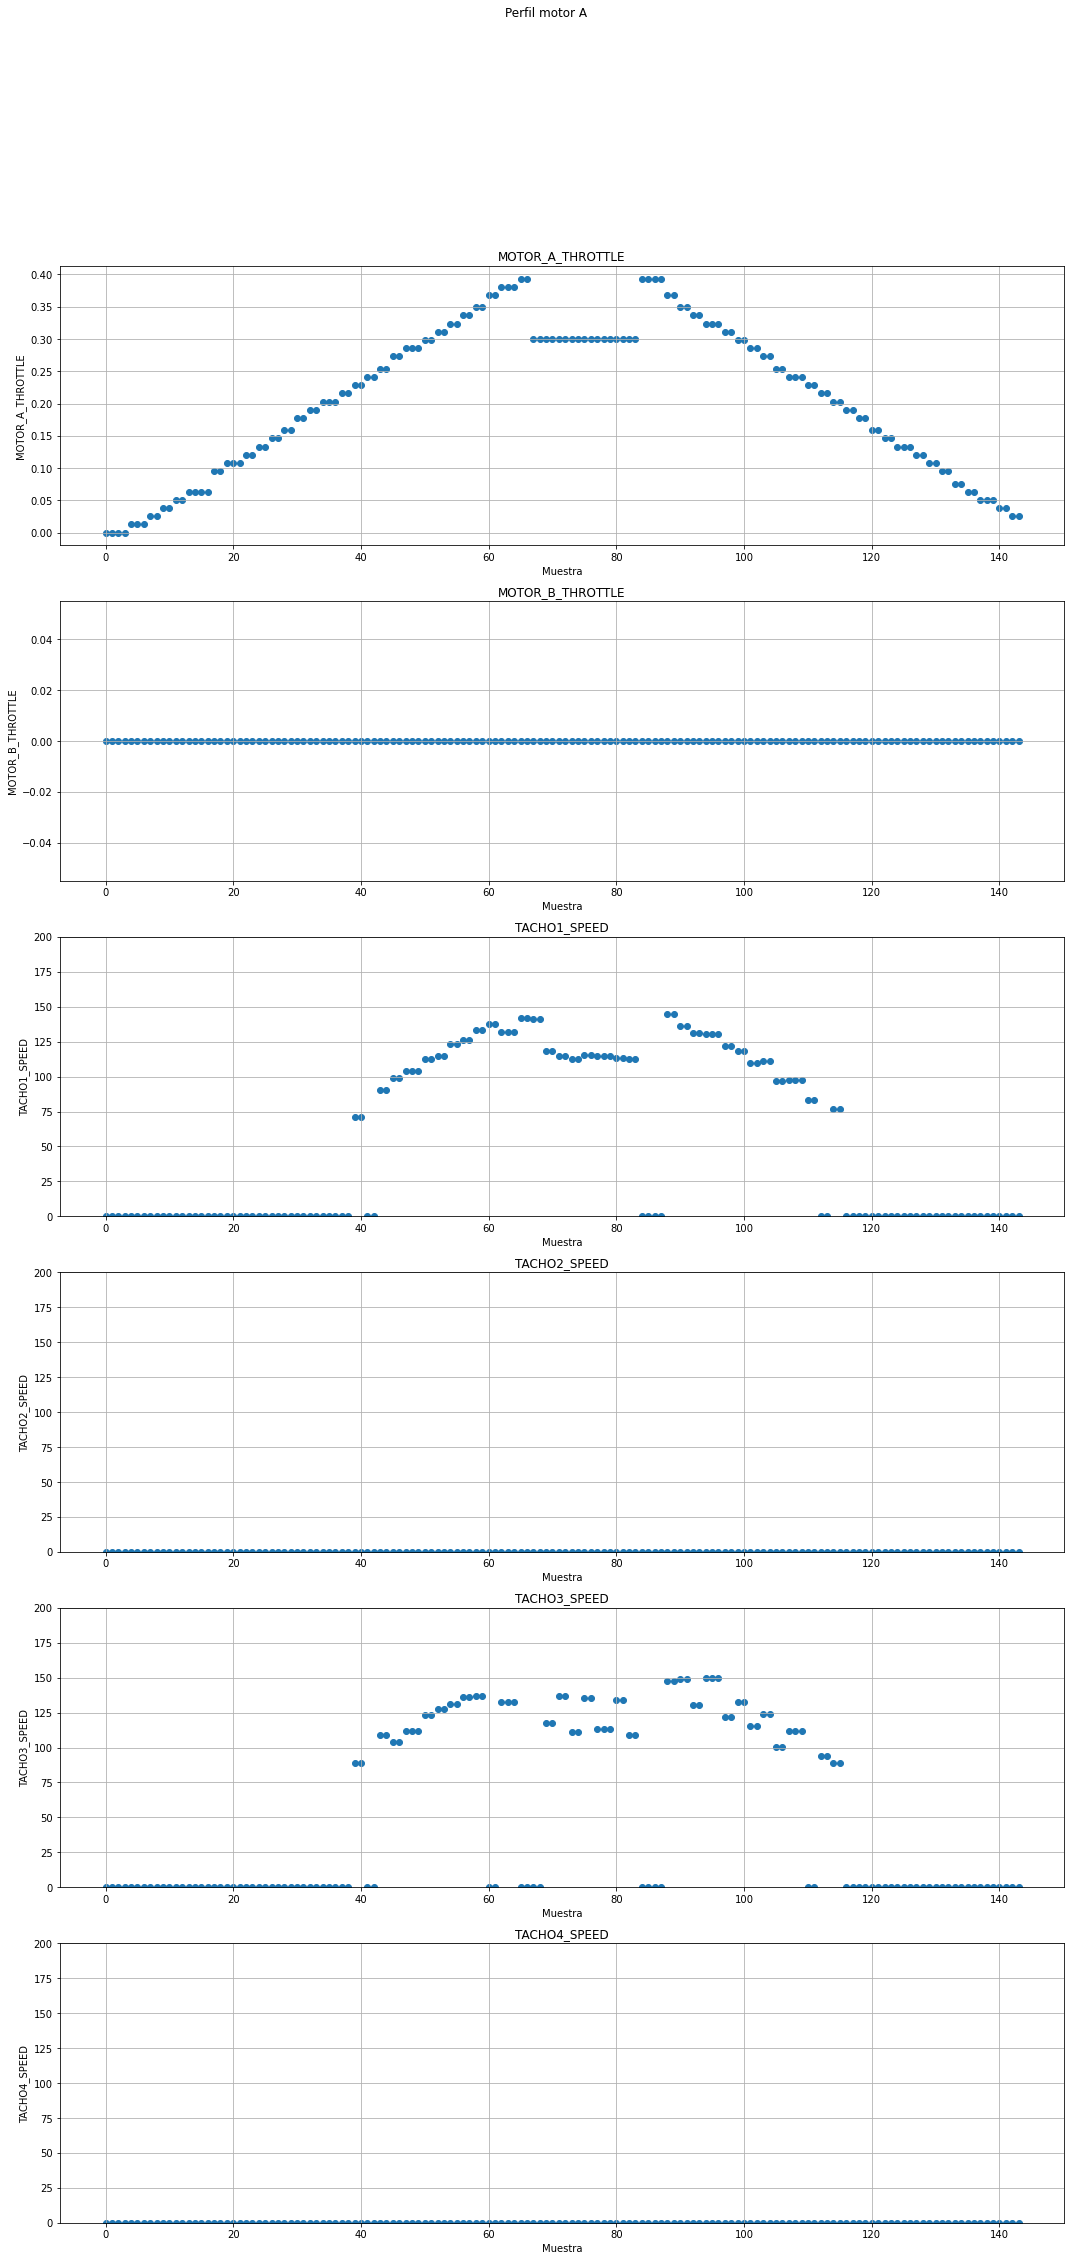

In [32]:
plot_motor_motion_profiles(tmy_readings,title="Perfil motor A")

Moverse hacia adelante incrementando la velocidad gradualmente, mantenerla por unos segundos, y decrementar (motor B).

In [34]:
ramp_up = np.array([ 
    np.linspace(0,0, N_ITERATIONS),            # MOTOR A
    np.linspace(0,MAX_THROTTLE, N_ITERATIONS)  # MOTOR B
])

sustain = np.vstack([
        np.zeros(int(N_ITERATIONS/4)),                                 # MOTOR A
        np.full((1,int(N_ITERATIONS/4)),fill_value=SUSTAIN_THROTTLE)])  # MOTOR B

ramp_down = np.array([ 
    np.linspace(0,0, N_ITERATIONS),            # MOTOR A
    np.linspace(MAX_THROTTLE,0, N_ITERATIONS)  # MOTOR B
])
profile = np.hstack([ramp_up,sustain,ramp_down])

In [35]:
tmy_readings = play_program_and_record_tmy(rover,profile,INTERVAL)

# Detener
rover.set_motor_throttles( 
    [0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

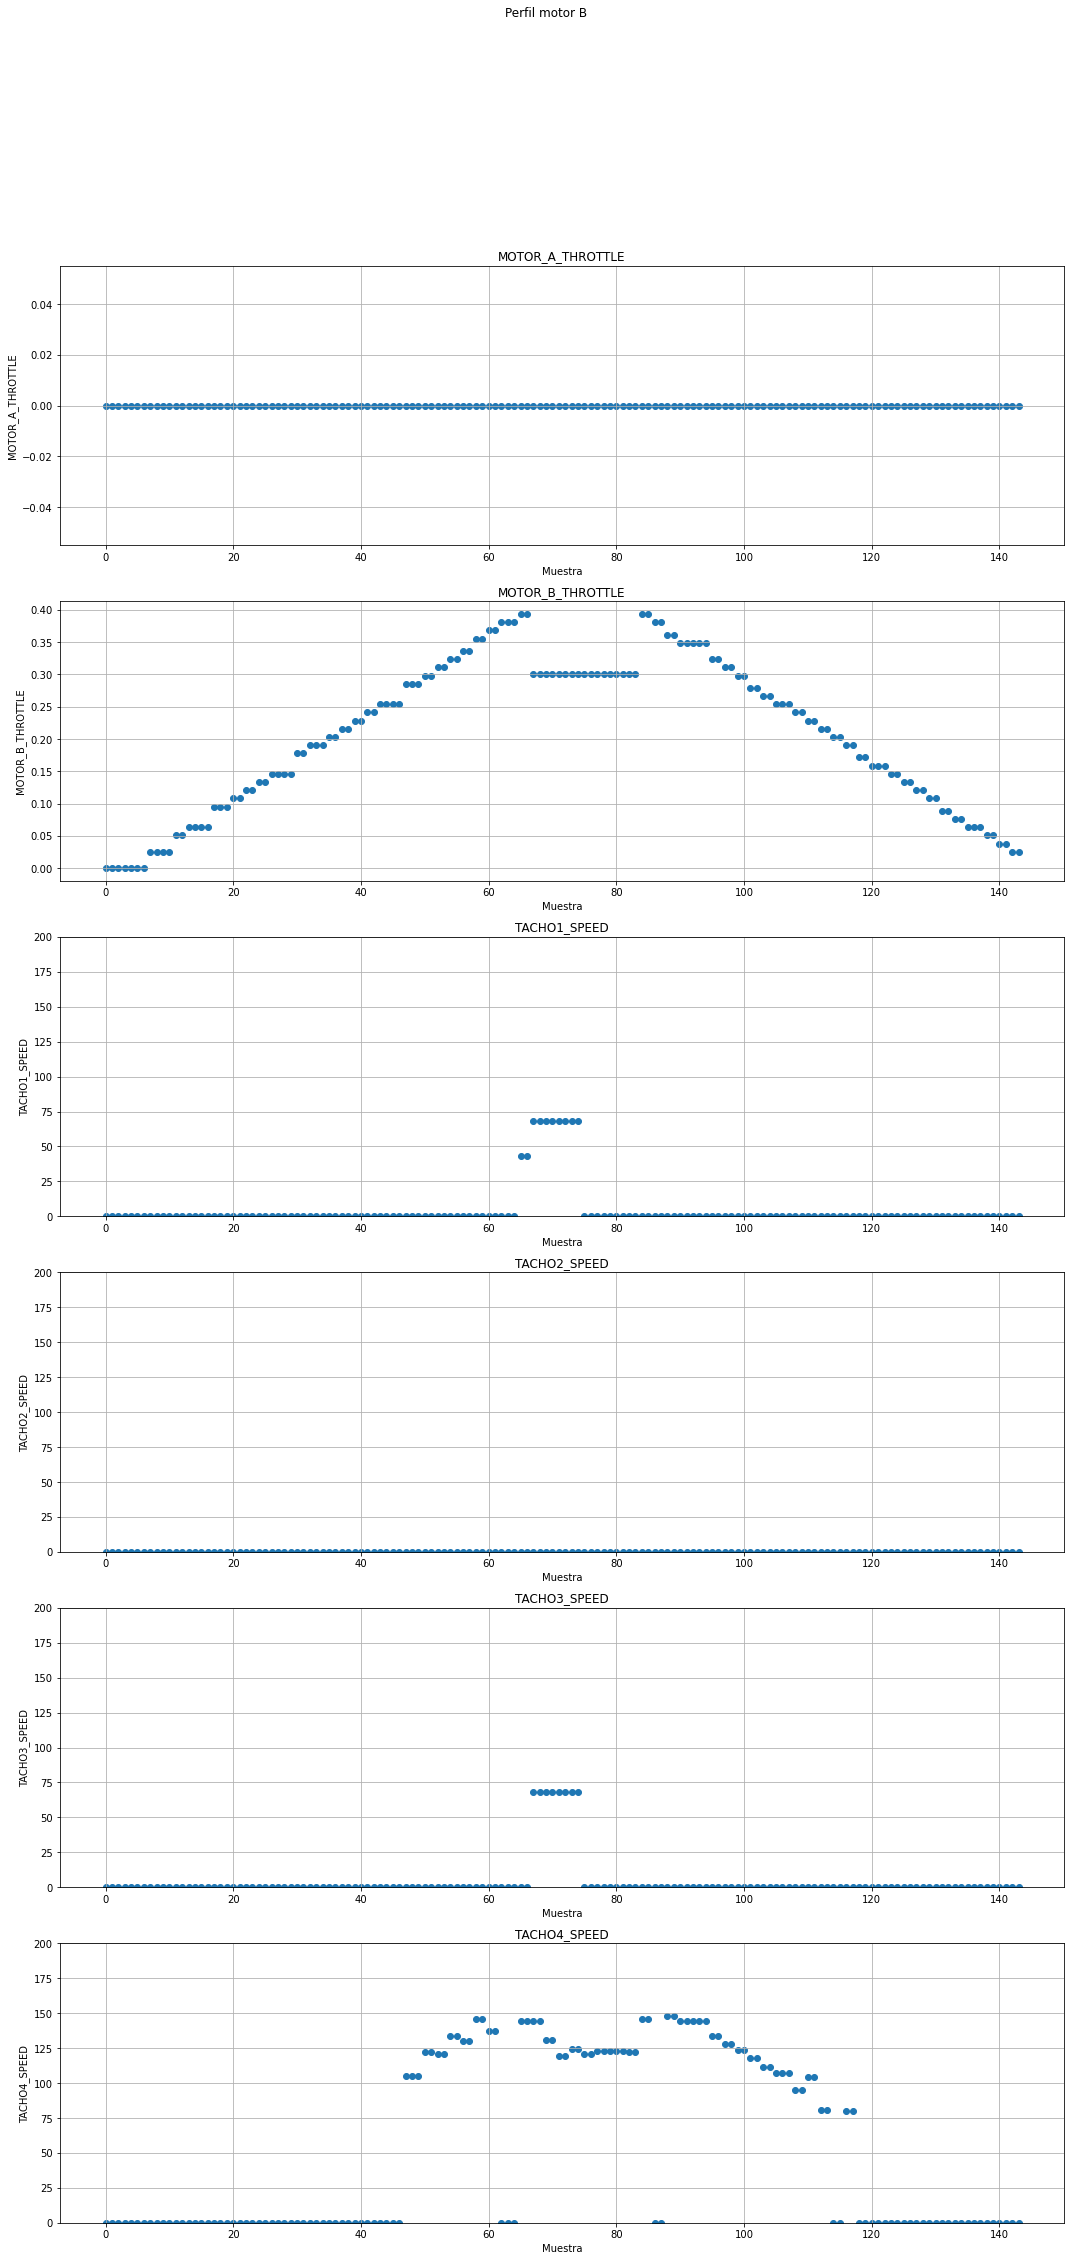

In [37]:
plot_motor_motion_profiles(tmy_readings,title="Perfil motor B")

## 5. Test de lectura de tacómetros

Iniciar la prueba en reposo.

In [38]:
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

Función para capturar valores de potencia aplicados y lecturas de tacómetros.

In [39]:
def capture_and_plot_tachometer_tmy(samples = 512,interval=0.01):
    tmy_readings = []
    for i in range(samples):
        tmy_readings.append( np.array([ i, 
            rover.TMY_PARAM_MOTOR_A_THROTTLE, rover.TMY_PARAM_MOTOR_B_THROTTLE,
            rover.TMY_PARAM_TACHO1_SPEED,
            rover.TMY_PARAM_TACHO2_SPEED,
            rover.TMY_PARAM_TACHO3_SPEED,
            rover.TMY_PARAM_TACHO4_SPEED]) )    
        time.sleep(interval)    
    tmy_readings = np.array(tmy_readings)
    fig,axes = plt.subplots(2,1,figsize=(18,10))
    axes[0].plot(tmy_readings[:,0],tmy_readings[:,1])
    axes[0].plot(tmy_readings[:,0],tmy_readings[:,2])
    
    axes[1].plot(tmy_readings[:,0],tmy_readings[:,3])
    axes[1].plot(tmy_readings[:,0],tmy_readings[:,2])
    axes[1].plot(tmy_readings[:,0],tmy_readings[:,5])
    axes[1].plot(tmy_readings[:,0],tmy_readings[:,6])
    
    axes[0].grid(which="Both")
    axes[1].grid(which="Both")
    axes[0].legend( ["MOTOR_A_THROTTLE", "MOTOR_B_THROTTLE"] )
    axes[1].legend( ["TACHO1_SPEED", "TACHO2_SPEED", "TACHO3_SPEED", "TACHO4_SPEED"])
    axes[0].set_title("Potencia aplicada a motores A/B");
    axes[1].set_title("Lectura de tacómetros");
    axes[0].set_xlabel("Muestra")
    axes[1].set_xlabel("Muestra")
    axes[0].set_xlabel("Potencia")
    axes[1].set_xlabel("RPM")
    return 

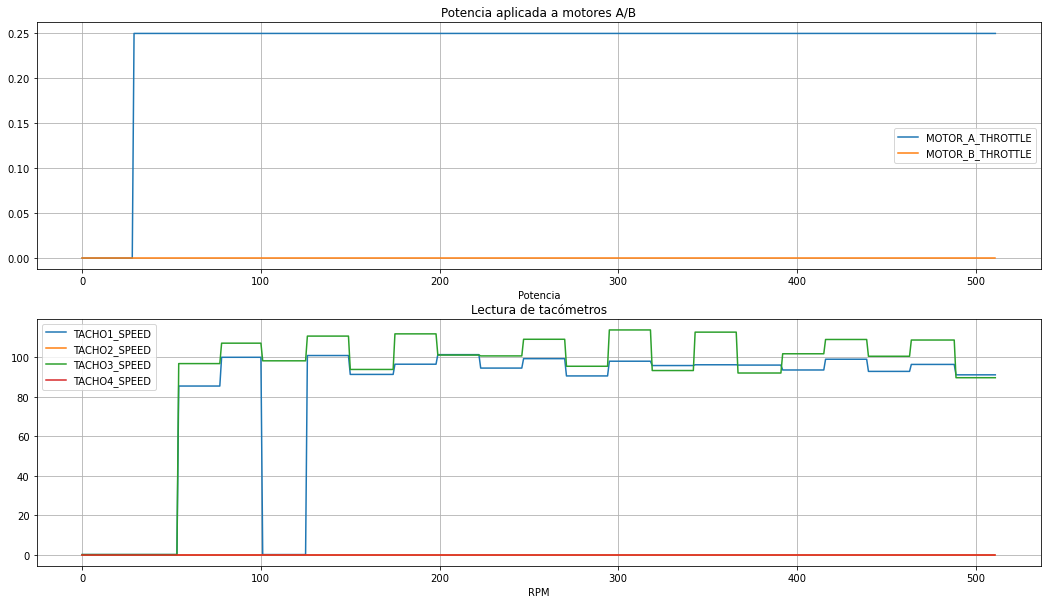

In [40]:
rover.set_motor_throttles([0.25, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
tmy_readings = capture_and_plot_tachometer_tmy(512)
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

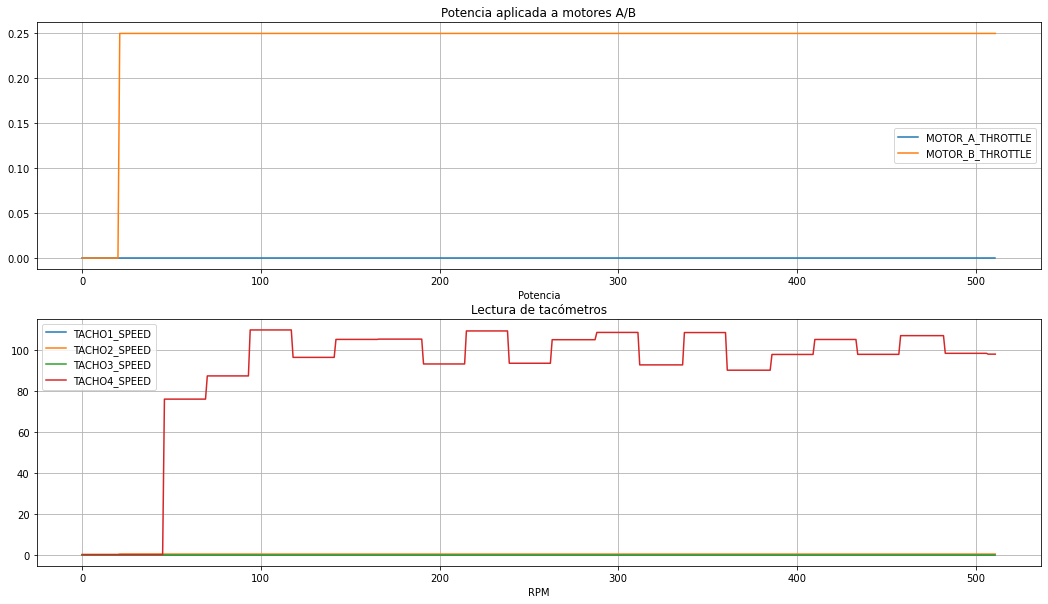

In [42]:
rover.set_motor_throttles([0, 0.25], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
tmy_readings = capture_and_plot_tachometer_tmy(512)
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

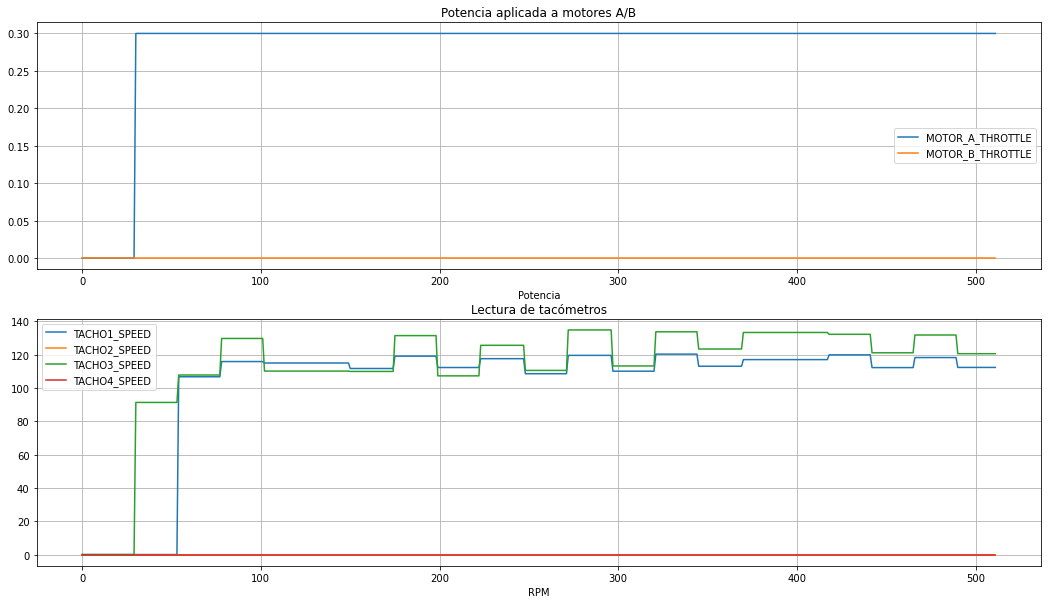

In [43]:
rover.set_motor_throttles([0.3, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
tmy_readings = capture_and_plot_tachometer_tmy(512)
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

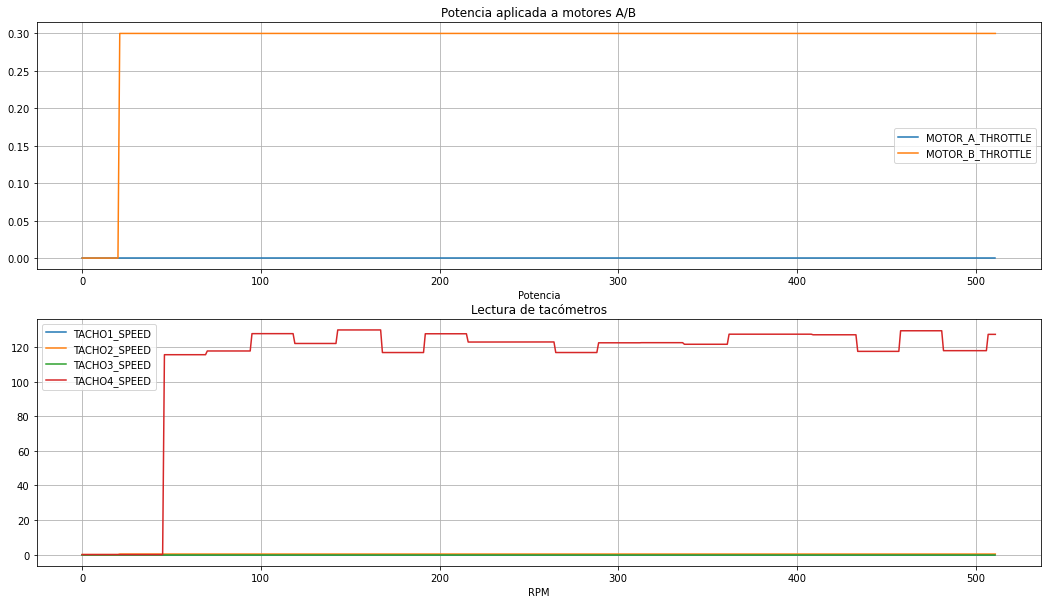

In [44]:
rover.set_motor_throttles([0.0, 0.3], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
tmy_readings = capture_and_plot_tachometer_tmy(512)
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

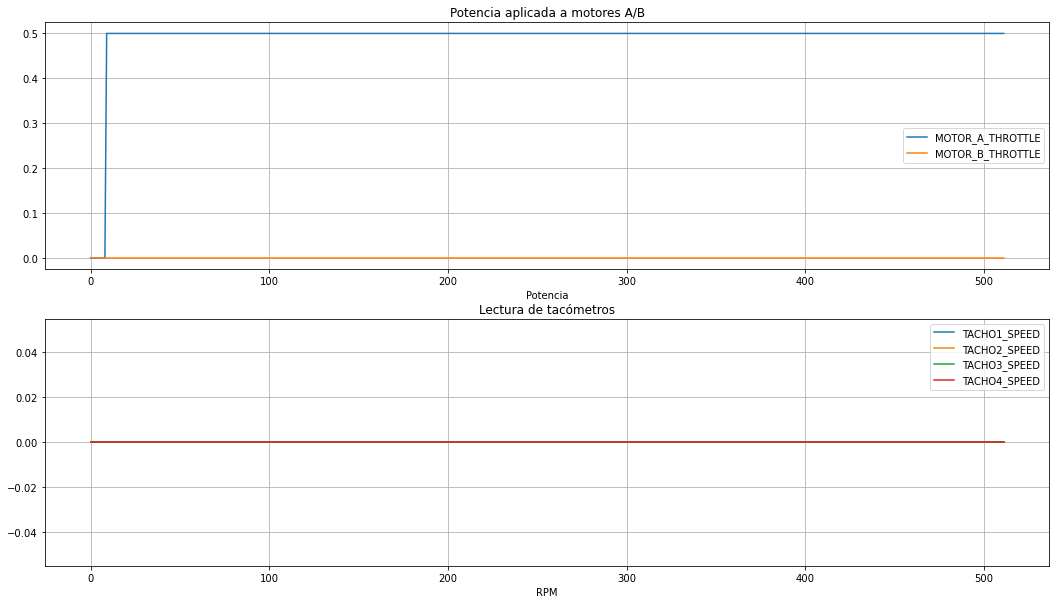

In [45]:
rover.set_motor_throttles([0.5, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
tmy_readings = capture_and_plot_tachometer_tmy(512)
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

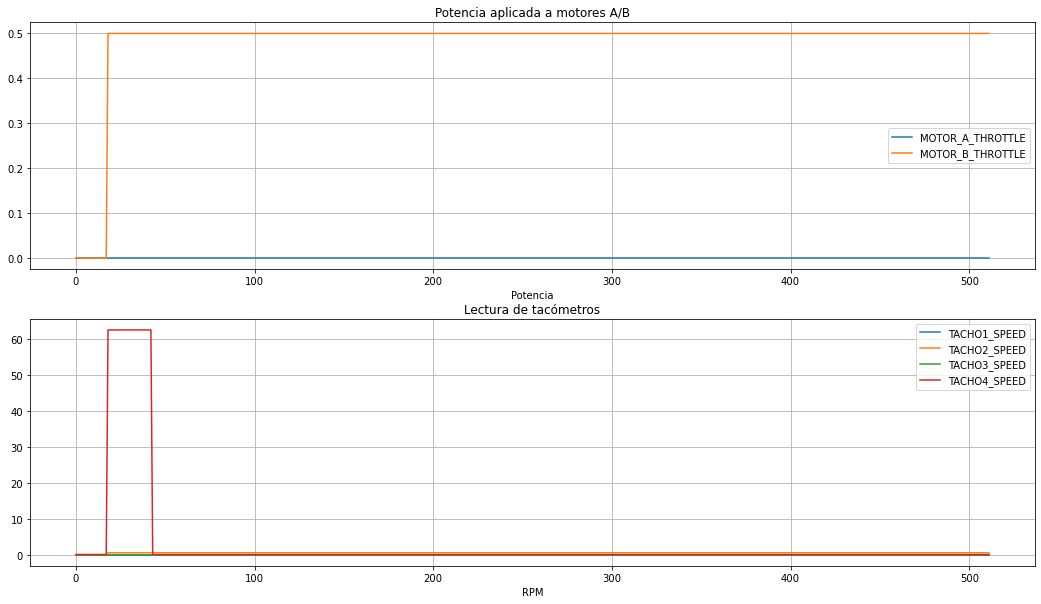

In [46]:
rover.set_motor_throttles([0.0, 0.5], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
tmy_readings = capture_and_plot_tachometer_tmy(512)
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )

## 6. Test de lectura de IMU

En este caso se leen las telemetrías del IMU (valores de ingeniería). 

Nota: el cuaternión está orientado a ROS, para HMI se requiere convertir a ángulos en grados.

In [508]:
rover.print_imu_state()

IMU_ENG_ACCEL_X: -0.190
IMU_ENG_ACCEL_Y: -0.471
IMU_ENG_ACCEL_Z: 0.081
IMU_ENG_GYRO_X: -35.789
IMU_ENG_GYRO_Y: -84.854
IMU_ENG_GYRO_Z: -20.974
IMU_ENG_MAG_X: 182.926
IMU_ENG_MAG_Y: 110.955
IMU_ENG_MAG_Z: -365.851
IMU_TEMP: 27.320
IMU_QUAT_X: 0.461
IMU_QUAT_Y: -0.047
IMU_QUAT_Z: 0.497
IMU_QUAT_W: -0.733


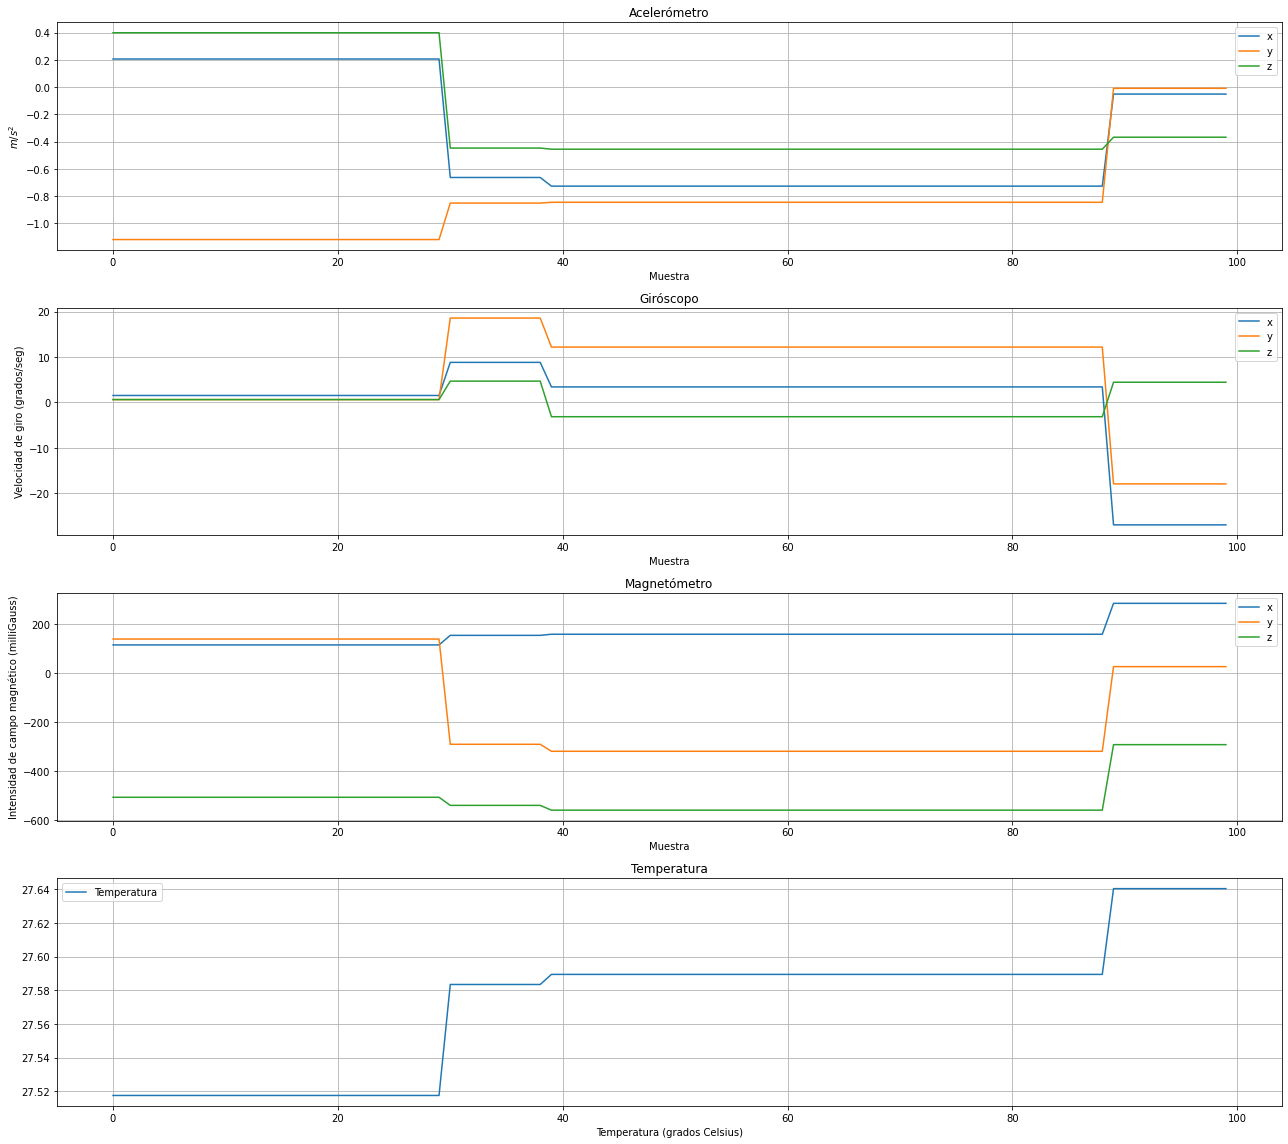

In [509]:
N_SAMPLES = 100
INTERVAL = 0.1
tmy_readings=[]
for i in range(N_SAMPLES):
    tmy_readings.append(np.array([i,
        rover.TMY_PARAM_IMU_ENG_ACCEL_X,
        rover.TMY_PARAM_IMU_ENG_ACCEL_Y,
        rover.TMY_PARAM_IMU_ENG_ACCEL_Z,
        rover.TMY_PARAM_IMU_ENG_GYRO_X,
        rover.TMY_PARAM_IMU_ENG_GYRO_Y,
        rover.TMY_PARAM_IMU_ENG_GYRO_Z,
        rover.TMY_PARAM_IMU_ENG_MAG_X,
        rover.TMY_PARAM_IMU_ENG_MAG_Y,
        rover.TMY_PARAM_IMU_ENG_MAG_Z,
        rover.TMY_PARAM_IMU_TEMP]))
    time.sleep(INTERVAL)
tmy_readings = np.array(tmy_readings)
        
tmy_names = [
        "IMU_ENG_ACCEL_X", "IMU_ENG_ACCEL_Y", "IMU_ENG_ACCEL_Z"
        "IMU_ENG_GYRO_X", "IMU_ENG_GYRO_Y", "IMU_ENG_GYRO_Z",
        "IMU_ENG_MAG_X", "IMU_ENG_MAG_Y", "IMU_ENG_MAG_Z",
        "IMU_TEMP",
]    
        
fig,axes = plt.subplots(4,1,figsize=(18,16))
axes[0].set_title("Acelerómetro");
axes[0].plot(tmy_readings[:,0],tmy_readings[:,1+0])
axes[0].plot(tmy_readings[:,0],tmy_readings[:,1+1])
axes[0].plot(tmy_readings[:,0],tmy_readings[:,1+2])
axes[0].set_ylabel("$m/s^2$")

        
axes[1].set_title("Giróscopo");
axes[1].plot(tmy_readings[:,0],tmy_readings[:,1+3+0])
axes[1].plot(tmy_readings[:,0],tmy_readings[:,1+3+1])
axes[1].plot(tmy_readings[:,0],tmy_readings[:,1+3+2])
axes[1].set_ylabel("Velocidad de giro (grados/seg)")

axes[2].set_title("Magnetómetro");
axes[2].plot(tmy_readings[:,0],tmy_readings[:,1+6+0])
axes[2].plot(tmy_readings[:,0],tmy_readings[:,1+6+1])
axes[2].plot(tmy_readings[:,0],tmy_readings[:,1+6+2])
axes[2].set_ylabel("Intensidad de campo magnético (milliGauss)")

axes[3].set_title("Temperatura");
axes[3].plot(tmy_readings[:,0],tmy_readings[:,1+9+0])
axes[3].grid(which="Both")
axes[3].legend(["Temperatura"])
axes[3].set_xlabel("Muestra")      
axes[3].set_xlabel("Temperatura (grados Celsius)")

for i in range(3):
    axes[i].grid(which="Both")
    axes[i].legend(["x","y","z"])
    axes[i].set_xlabel("Muestra")
fig.tight_layout()

## 7. Test de lectura de GPS

In [ ]:
# No implementado

## 8. Test de lazo de control PID

In [48]:
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()

TACHO1_SPEED: 0.000
TACHO2_SPEED: 0.000
TACHO3_SPEED: 0.000
TACHO4_SPEED: 0.000
TACHO1_COUNT: 1353.000
TACHO2_COUNT: 9978.000
TACHO3_COUNT: 1196.000
TACHO4_COUNT: 1317.000
MOTOR_A_THROTTLE: 0.0
MOTOR_B_THROTTLE: 0.0
MOTOR_A_SETPOINT_SPEED: 0.000
MOTOR_B_SETPOINT_SPEED: 0.000


In [49]:
INTERVAL = 3

# Detenido
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()

# 10 RPM
rover.set_motor_speed_setpoint( 
    [30.0, 30.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# 20 RPM
rover.set_motor_speed_setpoint( 
    [20.0, 20.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# 30 RPM
rover.set_motor_speed_setpoint( 
    [30.0, 30.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# 40 RPM
rover.set_motor_speed_setpoint( 
    [40.0, 40.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# 50 RPM
rover.set_motor_speed_setpoint( 
    [50.0, 50.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# 40 RPM
rover.set_motor_speed_setpoint( 
    [40.0, 40.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# 30 RPM
rover.set_motor_speed_setpoint( 
    [30.0, 30.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# 20 RPM
rover.set_motor_speed_setpoint( 
    [20.0, 20.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# 10 RPM
rover.set_motor_speed_setpoint( 
    [30.0, 30.0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()
time.sleep(INTERVAL)

# Detenido
rover.set_motor_throttles([0, 0], RoverClient.MOTOR_A | RoverClient.MOTOR_B )
rover.print_motor_tmy()

TACHO1_SPEED: 0.000
TACHO2_SPEED: 0.000
TACHO3_SPEED: 0.000
TACHO4_SPEED: 0.000
TACHO1_COUNT: 1353.000
TACHO2_COUNT: 9978.000
TACHO3_COUNT: 1196.000
TACHO4_COUNT: 1317.000
MOTOR_A_THROTTLE: 0.0
MOTOR_B_THROTTLE: 0.0
MOTOR_A_SETPOINT_SPEED: 0.000
MOTOR_B_SETPOINT_SPEED: 0.000
TACHO1_SPEED: 0.000
TACHO2_SPEED: 0.000
TACHO3_SPEED: 0.000
TACHO4_SPEED: 0.000
TACHO1_COUNT: 1353.000
TACHO2_COUNT: 9978.000
TACHO3_COUNT: 1196.000
TACHO4_COUNT: 1317.000
MOTOR_A_THROTTLE: 0.0
MOTOR_B_THROTTLE: 0.0
MOTOR_A_SETPOINT_SPEED: 0.000
MOTOR_B_SETPOINT_SPEED: 0.000
TACHO1_SPEED: 78.105
TACHO2_SPEED: 0.000
TACHO3_SPEED: 100.217
TACHO4_SPEED: 116.356
TACHO1_COUNT: 1443.000
TACHO2_COUNT: 10335.000
TACHO3_COUNT: 1288.000
TACHO4_COUNT: 1411.000
MOTOR_A_THROTTLE: -1.0
MOTOR_B_THROTTLE: 0.3078269958496094
MOTOR_A_SETPOINT_SPEED: 30.000
MOTOR_B_SETPOINT_SPEED: 30.000
TACHO1_SPEED: 0.000
TACHO2_SPEED: 0.000
TACHO3_SPEED: 0.000
TACHO4_SPEED: 62.168
TACHO1_COUNT: 1562.000
TACHO2_COUNT: 10650.000
TACHO3_COUNT: 1393.0

## Tear down

Desconectarse del rover para liberar el puerto serie.

In [50]:
rover.disconnect()